In [7]:
# clear all the variables
%reset -f

In [8]:
# import the relevant libraries
import time
import numpy as np
from random import randint
import matplotlib.pyplot as plt
from scipy.stats import norm, moment
from math import gamma, sin, pi

## Approximate circulant method
  The spectral simulation approach allows us to replace the exact values of $\lambda_k$ in the Davis and Harte method to generate the sample. The Fourier transformation is now applied to 
  
$$
c_k = \left\{ 
\begin{array}{ll}
\sqrt{\frac{f(t_k)}{2N}}U_{k}^{(0)} & k=0\\
\sqrt{\frac{f(t_k)}{4N}}\left(U_{k}^{(0)} + iU_{k}^{(1)}\right) & k=1,\ldots ,N-1\\
\sqrt{\frac{f(t_k)}{2N}}U_{k}^{(0)} & k=N\\
\sqrt{\frac{f(t_{2N-k})}{4N}}\left(U_{2N-k}^{(0)} - iU_{2N-k}^{(1)}\right) & k=N+1,\ldots ,2N-1\\
\end{array}
\right.
$$

The first $N$ coefficients of the Fourier transform constitute an approximate fGn sample.

In [9]:
# we define some useful functions

# returns the estimate for B_3(lambda, H)
def b3Est(l, H, debug = False):
    d = -2.0 * H - 1.0
    dprime = -2.0 * H
    
    res = (6.0 * pi + l) ** dprime + (6.0 * pi - l) ** dprime + (8.0 * pi + l) ** dprime + (8.0 * pi - l) ** dprime
            
    res = res / (8.0 * H * pi)
    
    res = res + (2.0 * pi + l) ** d + (2.0 * pi - l) ** d
    res = res + (4.0 * pi + l) ** d + (4.0 * pi - l) ** d
    return res + (6.0 * pi + l) ** d + (6.0 * pi - l) ** d
    
# returns the adjusted estimate
def bEstAdj(l, H, debug = False):
    return (1.0002 - 0.000134 * l) * (b3Est(l, H, debug) - 2.0 ** (-7.65 * H - 7.64))
    
# approximate the spectral density of the process
def spectrum(l, H, debug = False):
    g = gamma(2.0 * H + 1.0)
    return 2.0 * np.sin(pi * H) * g * (1.0 - np.cos(l)) * (abs(l) ** (-2.0 * H - 1.0) + bEstAdj(l, H, debug))

In [14]:
def approximateCirculantMethod(H, n, T, seed = None, debug = False):
    # compute the spectral sequence of a fractional Brownian Motion
    # - H: the Hurst exponent
    # - n: determines the size of the sample (sz = 2^n)
    # - T: max time
    # - cum: boolean indicating if we accumulate
    # - seed: the seed for RNG for debugging
    # returns an array of complex numbers
    # TODO: not clear how T has to be used here
    
    N = 2 ** n
    np.random.seed(seed)
    bks = np.zeros((2 * N,), dtype=np.complex_)
    u_0 = 0.0; u_1 = 0.0
    
    bks[0] = np.sqrt(spectrum(0.0 / float(N), H, debug) / (2 * N)) * np.random.randn()
    bks[N] = np.sqrt(spectrum(1.0 / float(N), H, debug) / (2 * N)) * np.random.randn()
    
    for i in range(1, N - 1):
        u_0 = np.random.randn()
        u_1 = np.random.randn()
        bks[i] = np.sqrt(spectrum(float(i) / float(N), H, debug) / (4.0 * N)) * (u_0  + 1.j * u_1)
        bks[2 * N - i] = np.sqrt(spectrum(float(i) / float(N), H, debug) / (4.0 * N)) * (u_0  - 1.j * u_1)

    return bks

In [15]:
# compute some spectral sequences for H=0.6, 0.8
n = 15
H = [0.6, 0.8]
res = [approximateCirculantMethod(h, n, 1.0, None, False) for h in H]

fig = plt.figure(figsize=(16, 10))
ax = fig.add_subplot(221)
ax.plot([r.real for r in res[0]])
ax.set_title('spectral sequence for H = {0} (real part)'.format(H[0]))

ax = fig.add_subplot(222)
ax.plot([r.real for r in res[1]])
ax.set_title('spectral sequence for H = {0} (real part)'.format(H[1]))

fig.subplots_adjust(hspace=.5)
plt.show()

ZeroDivisionError: 0.0 cannot be raised to a negative power

In [96]:
# The paxson method
def paxson(H, n, T, cum, seed = None, debug = False):

    if cum == True:
        return np.cumsum([r.real for r in np.fft.fft(spectralSequence(H, n, T, seed, debug))])
    else:
        return [r.real for r in np.fft.fft(spectralSequence(H, n, T, seed, debug))]

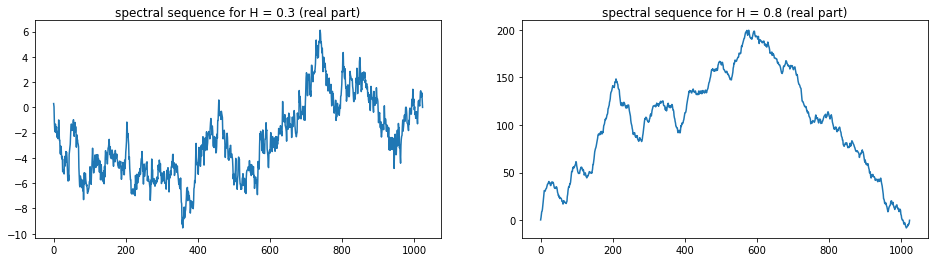

In [97]:
# generate path using the paxson method
n = 10
H = [0.3, 0.8]
res = [paxson(h, n, 1.0, True, None) for h in H]

fig = plt.figure(figsize=(16, 10))
ax = fig.add_subplot(221)
ax.plot(res[0])
ax.set_title('spectral sequence for H = {0} (real part)'.format(H[0]))

ax = fig.add_subplot(222)
ax.plot(res[1])
ax.set_title('spectral sequence for H = {0} (real part)'.format(H[1]))

fig.subplots_adjust(hspace=.5)
plt.show()

computation done in 13.1789859342 seconds


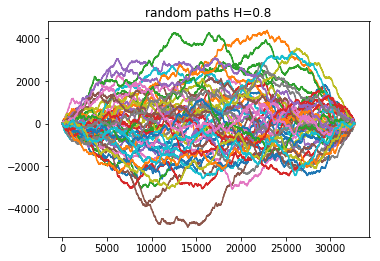

In [102]:
# generate N paths with H = 0.8 coefficient 
H = 0.8
T = 1.0
size = 15
N = 50

start = time.clock()
res = [paxson(H, size, T, cum=True, seed=None) for x in range(N)]
print("computation done in {} seconds".format(time.clock() - start))

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(221)

ts = [[]];
for i in res:
    ts[0] = ts[0] + ax.plot(i)

ax.set_title('random paths H={}'.format(H))
ax.legend(loc='center right', bbox_to_anchor=(-0.08, 0.5))

# get the terminal values
#term = [[i.get_ydata()[-1] for i in j] for j in ts]

# create the histograms
#binwidth = 1

#ax3 = fig.add_subplot(223)
#ax3.title.set_text('terminal vol distribution H=' + str(hurst[0]))
#ax3.hist(term[0], bins=np.arange(min(term[0]), max(term[0]) + binwidth, binwidth))
#ax3.set_xlabel("volatility")

#ax4 = fig.add_subplot(224)
#ax4.title.set_text('terminal vol distribution H=' + str(hurst[1]))
#ax4.hist(term[1], bins=np.arange(min(term[1]), max(term[1]) + binwidth, binwidth))
#ax4.set_xlabel("volatility")

fig.tight_layout()
fig.subplots_adjust(hspace=.5)
plt.show()

In [63]:
print([[moment(x, i) for i in range(1, 5)] for x in term])

[[0.0, 6.260623848657362, -0.97791548872506184, 122.85763717429998], [0.0, 15.484246268804961, 1.8522533737557583, 726.36351540511941]]
